# Time series forecasting with Prophet

In [1]:
from modules import utils
utils.configure_plotly_template(showlegend=True)

## Load Data

In [2]:
path = "../../../data/statsmodels/AirPassengers.parquet"

In [3]:
import pandas as pd

df = pd.read_parquet(path).asfreq('ME')
df.columns = ['values']

series = df['values']
series

1949-01-31    112
1949-02-28    118
             ... 
1960-11-30    390
1960-12-31    432
Freq: ME, Name: values, Length: 144, dtype: int64

## Prepare DataFrame for Prophet

In [4]:
df = pd.DataFrame({
    'ds': series.index,
    'y': series.values,
}, index=series.index)

df

,ds,y
1949-01-31,1949-01-31,112
1949-02-28,1949-02-28,118
...,...,...
1960-11-30,1960-11-30,390
1960-12-31,1960-12-31,432


## Model fit

In [5]:
from prophet import Prophet

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'  # or 'additive'
)
model.fit(df)

09:31:01 - cmdstanpy - INFO - Chain [1] start processing
09:31:01 - cmdstanpy - INFO - Chain [1] done processing


## Forecast

In [6]:
future = model.make_future_dataframe(periods=48, freq='ME')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
187,1964-08-31,804.322300,780.928863,829.511326
188,1964-09-30,685.596010,665.487662,707.256383
...,...,...,...,...
190,1964-11-30,525.884549,506.899635,545.962434
191,1964-12-31,583.970836,563.991531,604.830899


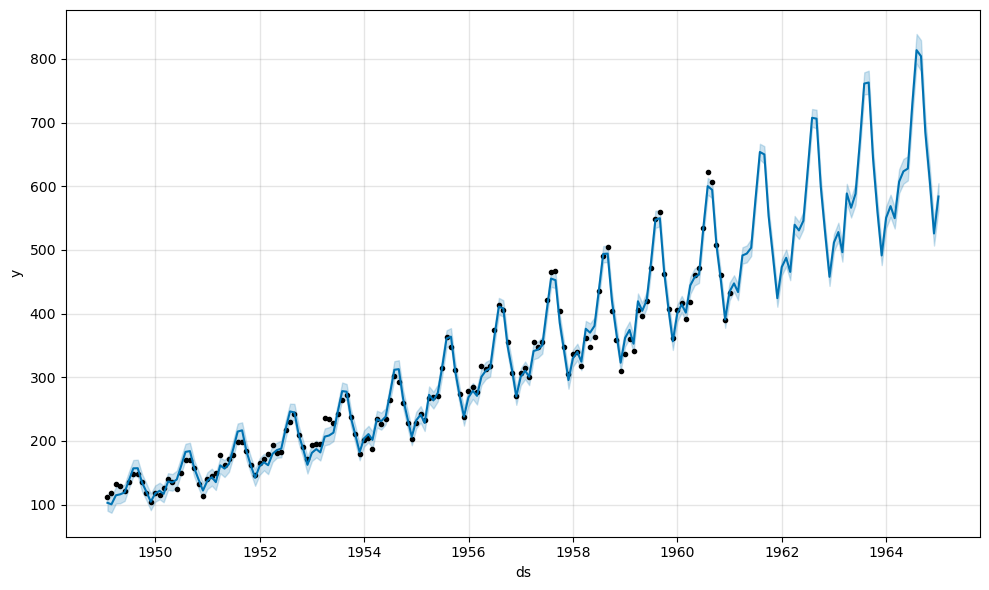

In [7]:
model.plot(forecast);

In [8]:
utils.plot_prophet_forecast(df['y'], forecast)

## Variation Playground

In [9]:
from prophet import Prophet

def fit_prophet(df, mode="multiplicative"):
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        seasonality_mode=mode
    )
    m.fit(df)
    future = m.make_future_dataframe(periods=48, freq='ME')
    fc = m.predict(future)
    return fc[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': f"forecast_{mode}"})

df_add = fit_prophet(df, mode="additive")
df_mul = fit_prophet(df, mode="multiplicative")

combined = df.set_index('ds').join(df_add).join(df_mul)
combined.plot()

09:31:02 - cmdstanpy - INFO - Chain [1] start processing
09:31:02 - cmdstanpy - INFO - Chain [1] done processing
09:31:02 - cmdstanpy - INFO - Chain [1] start processing
09:31:02 - cmdstanpy - INFO - Chain [1] done processing


## Configuration

1. Prophet automatically detects trend and seasonality using changepoints.
2. You configure:

   * **Trend flexibility** (with or without change points)
   * **Additive vs. multiplicative** seasonality (`seasonality_mode`)
   * **Custom seasonalities** (optional)
   * **Holiday effects** (optional)


**📌 Rule of Thumb**

> “Prophet config is semi-automatic: trend and seasonal components are learned with flexible change points. You choose seasonal mode and horizon — minimal tuning required.”

**Seasonal decomposition for visual insight only.**

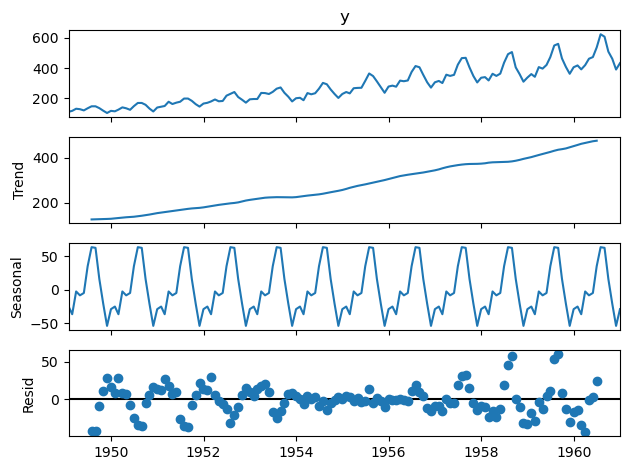

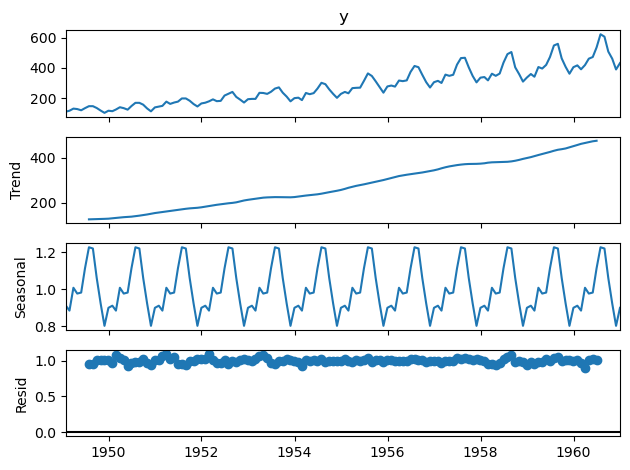

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df['y'], model="additive", period=12).plot();
seasonal_decompose(df['y'], model="multiplicative", period=12).plot();

## Diagnostics and assumptions

Although Prophet is robust and doesn’t require stationarity or normal residuals, residual analysis helps confirm quality.

### Residual calculation

In [11]:
df_forecast = forecast.set_index("ds")[['yhat']].join(df.set_index("ds"))
df_forecast['residuals'] = df_forecast['y'] - df_forecast['yhat']

residuals = df_forecast['residuals'].dropna()
residuals

ds
1949-01-31     9.102743
1949-02-28    17.532820
                ...    
1960-11-30    -0.823304
1960-12-31    -2.804351
Name: residuals, Length: 144, dtype: float64

### Autocorrelation

#### Plot

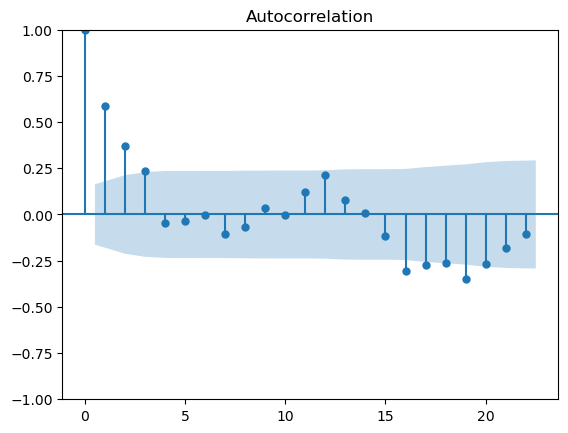

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals);

#### Test: Ljung-Box

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(residuals, lags=[10, 20, 30]).style

,lb_stat,lb_pvalue
10,82.668229,0.000000
20,167.529442,0.000000
30,219.288026,0.000000


### Normality

#### Plot

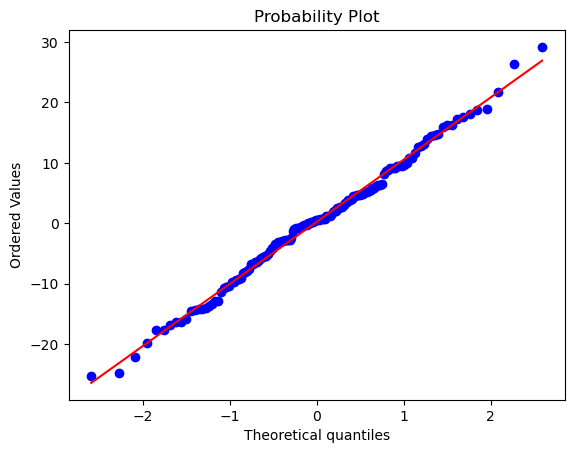

In [14]:
from scipy import stats
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
stats.probplot(residuals, dist='norm', plot=ax);

#### Test: Jarque-Bera

In [15]:
from scipy.stats import jarque_bera
jarque_bera(residuals)

SignificanceResult(statistic=np.float64(0.018871983201470002), pvalue=np.float64(0.9906083876708386))

### Homoscedasticity

#### Plot

In [16]:
residuals.plot()

#### Test

In [17]:
from statsmodels.stats.diagnostic import het_arch
het_arch(residuals)

(np.float64(16.596914206299374),
 np.float64(0.08377279981299146),
 1.7388132803953582,
 0.0793106680683477)

## ✅ Final Takeaway

> “Prophet provides quick and flexible forecasts. Diagnostics help validate performance — even if residuals aren’t perfect, low autocorrelation and reasonable error distribution often indicate a usable model.”

In [15]:
pd.options.plotting.backend = "matplotlib"

09:20:41 - cmdstanpy - INFO - Chain [1] start processing
09:20:41 - cmdstanpy - INFO - Chain [1] done processing
/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.



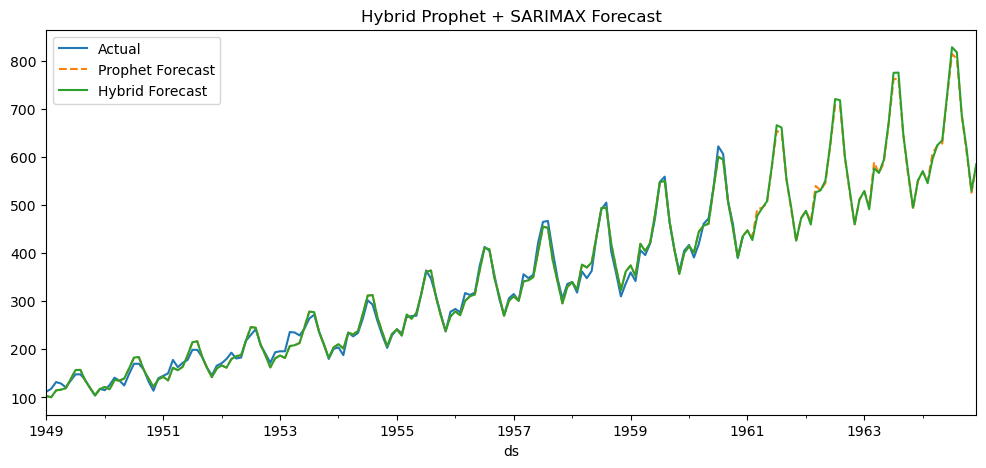

In [17]:
import pandas as pd
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Load data
path = "../../../data/statsmodels/AirPassengers.parquet"
df = pd.read_parquet(path).asfreq("ME")
df.columns = ["y"]
df["ds"] = df.index
df = df[["ds", "y"]]

# ----------------------------
# 1. Prophet: Trend + Seasonality
# ----------------------------
prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",  # similar to SARIMAX seasonal effect
)
prophet.fit(df)

# Forecast horizon
future = prophet.make_future_dataframe(periods=48, freq="ME")
forecast_prophet = prophet.predict(future)

# Merge actuals + Prophet forecast
df_merged = df.set_index("ds").join(forecast_prophet.set_index("ds")[["yhat"]])
df_merged["residuals"] = df_merged["y"] - df_merged["yhat"]

# ----------------------------
# 2. SARIMAX: Fit residuals
# ----------------------------
# Drop NaNs from residuals
resid = df_merged["residuals"].dropna()

# Fit SARIMAX to residuals
model_sarimax = SARIMAX(
    resid,
    order=(0, 1, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarimax_fit = model_sarimax.fit()

# Forecast residuals
n_periods = 48
resid_forecast = sarimax_fit.forecast(steps=n_periods)

# Align forecast index with Prophet future
resid_forecast.index = forecast_prophet.iloc[-n_periods:]["ds"].values

# ----------------------------
# 3. Combine Forecasts
# ----------------------------
final_forecast = forecast_prophet.set_index("ds").copy()
final_forecast["hybrid_forecast"] = final_forecast["yhat"]
final_forecast.loc[resid_forecast.index, "hybrid_forecast"] += resid_forecast

# ----------------------------
# 4. Plot
# ----------------------------
plt.figure(figsize=(12, 5))
df.set_index("ds")["y"].plot(label="Actual")
final_forecast["yhat"].plot(label="Prophet Forecast", linestyle="--")
final_forecast["hybrid_forecast"].plot(label="Hybrid Forecast", linestyle="-")
plt.legend()
plt.title("Hybrid Prophet + SARIMAX Forecast")
plt.show()